In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf
print("tensorflow = {}".format(tf.__version__))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'densenet121.keras'

Keras = 2.15.0
tensorflow = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip
! unzip -o drive/MyDrive/Brain_MRI.zip

! pwd

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-gl_0732.jpg  
  inflating: Training/glioma/

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

## Data Distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

meningioma    120
glioma        120
pituitary     120
notumor       120
dtype: int64

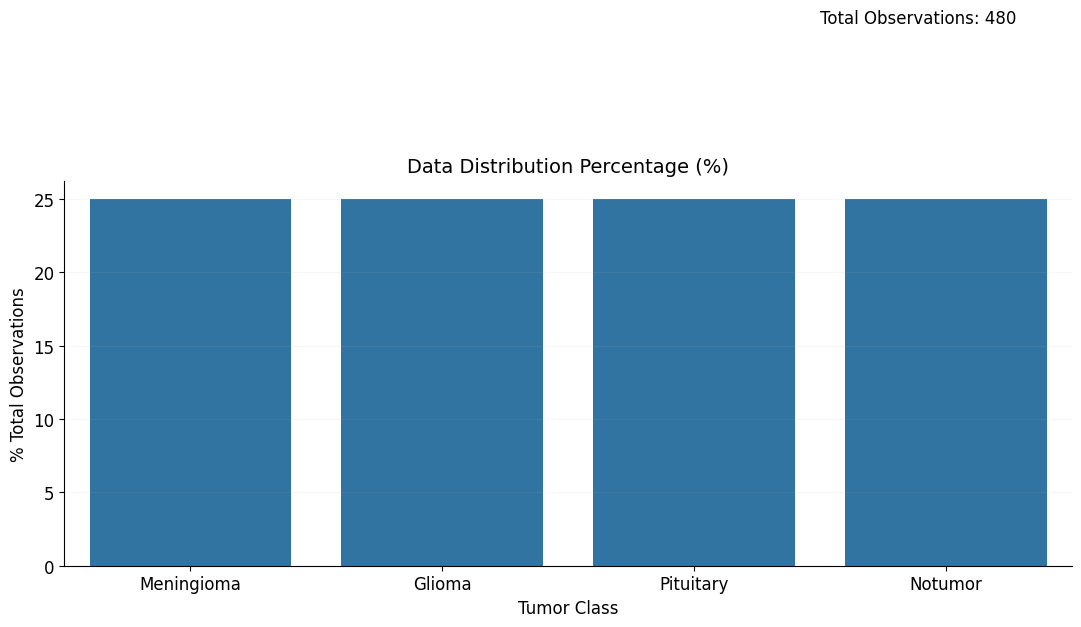

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data

In [7]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

	# Find extreme points on the image and crop the rectangular out

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            cv2.imwrite(img_path, cropped_img)

# Preprocess the images before generating data
preprocess_images(dir)
preprocess_images(validation_dir)

## Splitting the data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


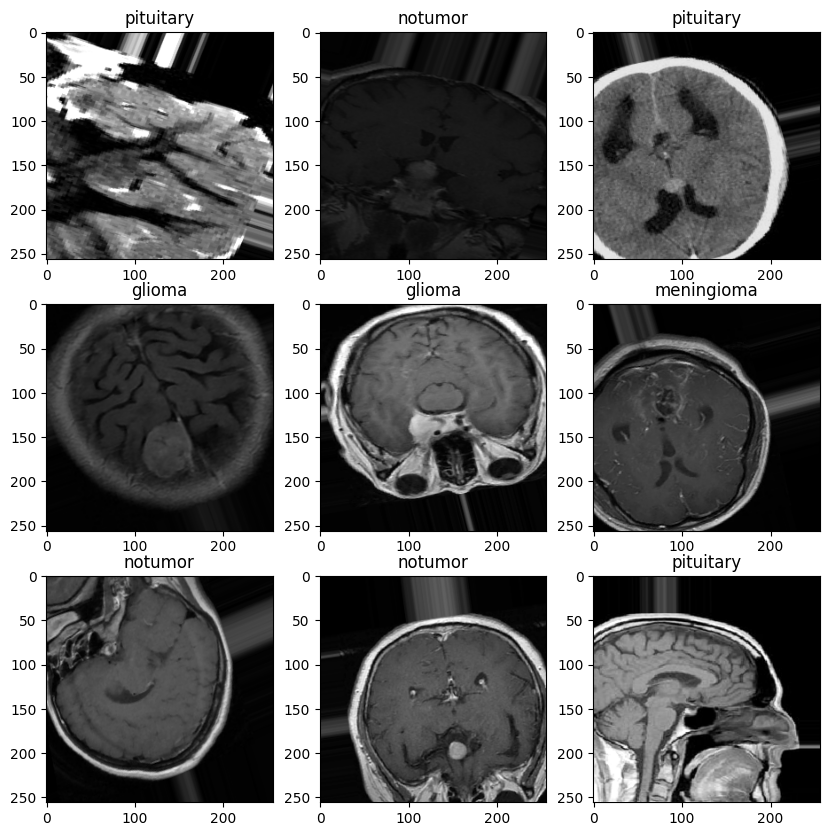

In [8]:
batch_size = 32

classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = [0.3, 1.5],
    fill_mode='nearest',
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=batch_size,
    seed=42,
    subset='validation')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    seed=42,
    batch_size=batch_size
)

print(test_generator.class_indices)

# Display 1 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        # Print Class
        plt.title(classes[np.argmax(Y_batch[0])])

        plt.imshow(image)
        break



# Training a DenseNet121 model

In [9]:
from keras.utils import plot_model
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

def create_model(input_shape, num_classes):

    # Load the pre-trained DenseNet121 model, excluding the top layers
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)  # Add Dropout layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Adjust the number of classes

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model
    # for layer in base_model.layers:
    #     layer.trainable = False
    for layer in base_model.layers[:300]:
      layer.trainable = False
    for layer in base_model.layers[300:]:
      layer.trainable = True

    # Add ReduceLROnPlateau callback to reduce the learning rate when a metric has stopped improving
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# # Check if the model exists
# if os.path.exists(model_file):
#     # Load the model from the file
#     model = load_model(model_file)
# else:
#     # Create a new model
#     model = create_model((256, 256, 3), len(classes))

model = create_model((256, 256, 3), len(classes))

plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.687516 to fit

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                

# Train the model

In [ ]:
# import shutil
# from google.colab import files

# # Replace 'my_folder' with the name of your folder
# folder_name = 'models'

# # Create a zip file
# shutil.make_archive(folder_name, 'zip', folder_name)

# # Download the zip file
# files.download(f'{folder_name}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)


# Newly Added
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
# Add ReduceLROnPlateau callback to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr] # Added reduce_lr
)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 2.3521 - accuracy: 0.4453
Epoch 1: val_loss improved from inf to 1.99573, saving model to ./models/densenet121.keras
12/12 [==============================] - 63s 2s/step - loss: 2.3521 - accuracy: 0.4453 - val_loss: 1.9957 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.8849 - accuracy: 0.6276
Epoch 2: val_loss improved from 1.99573 to 1.93189, saving model to ./models/densenet121.keras
12/12 [==============================] - 13s 1s/step - loss: 1.8849 - accuracy: 0.6276 - val_loss: 1.9319 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.6288 - accuracy: 0.7161
Epoch 3: val_loss improved from 1.93189 to 1.72566, saving model to ./models/densenet121.keras
12/12 [==============================] - 14s 1s/step - loss: 1.6288 - accuracy: 0.7161 - val_loss: 1.7257 - val_accuracy: 0.6146 - lr: 1.0000e-04

# Testing the Model

3/3 [==============================] - 2s 637ms/step - loss: 1.0403 - accuracy: 0.8750
Validation loss: 1.0403
Validation accuracy: 0.8750


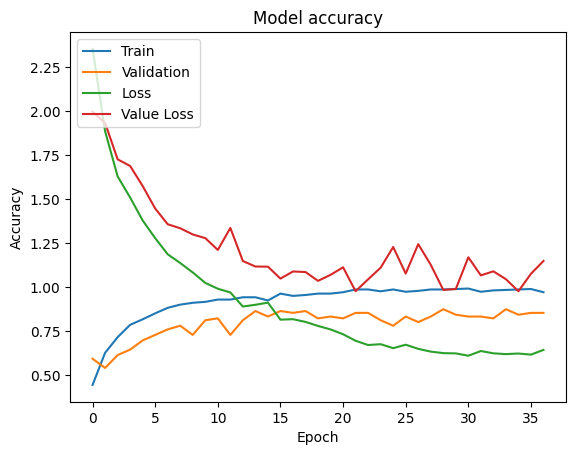

In [12]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Validation loss: {loss:.4f}')
print(f'Validation accuracy: {accuracy:.4f}')

# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

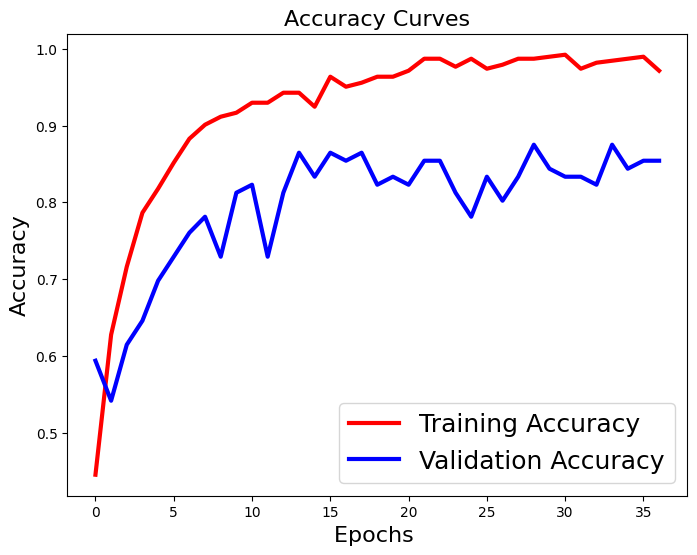

In [14]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

41/41 [==============================] - 6s 107ms/step


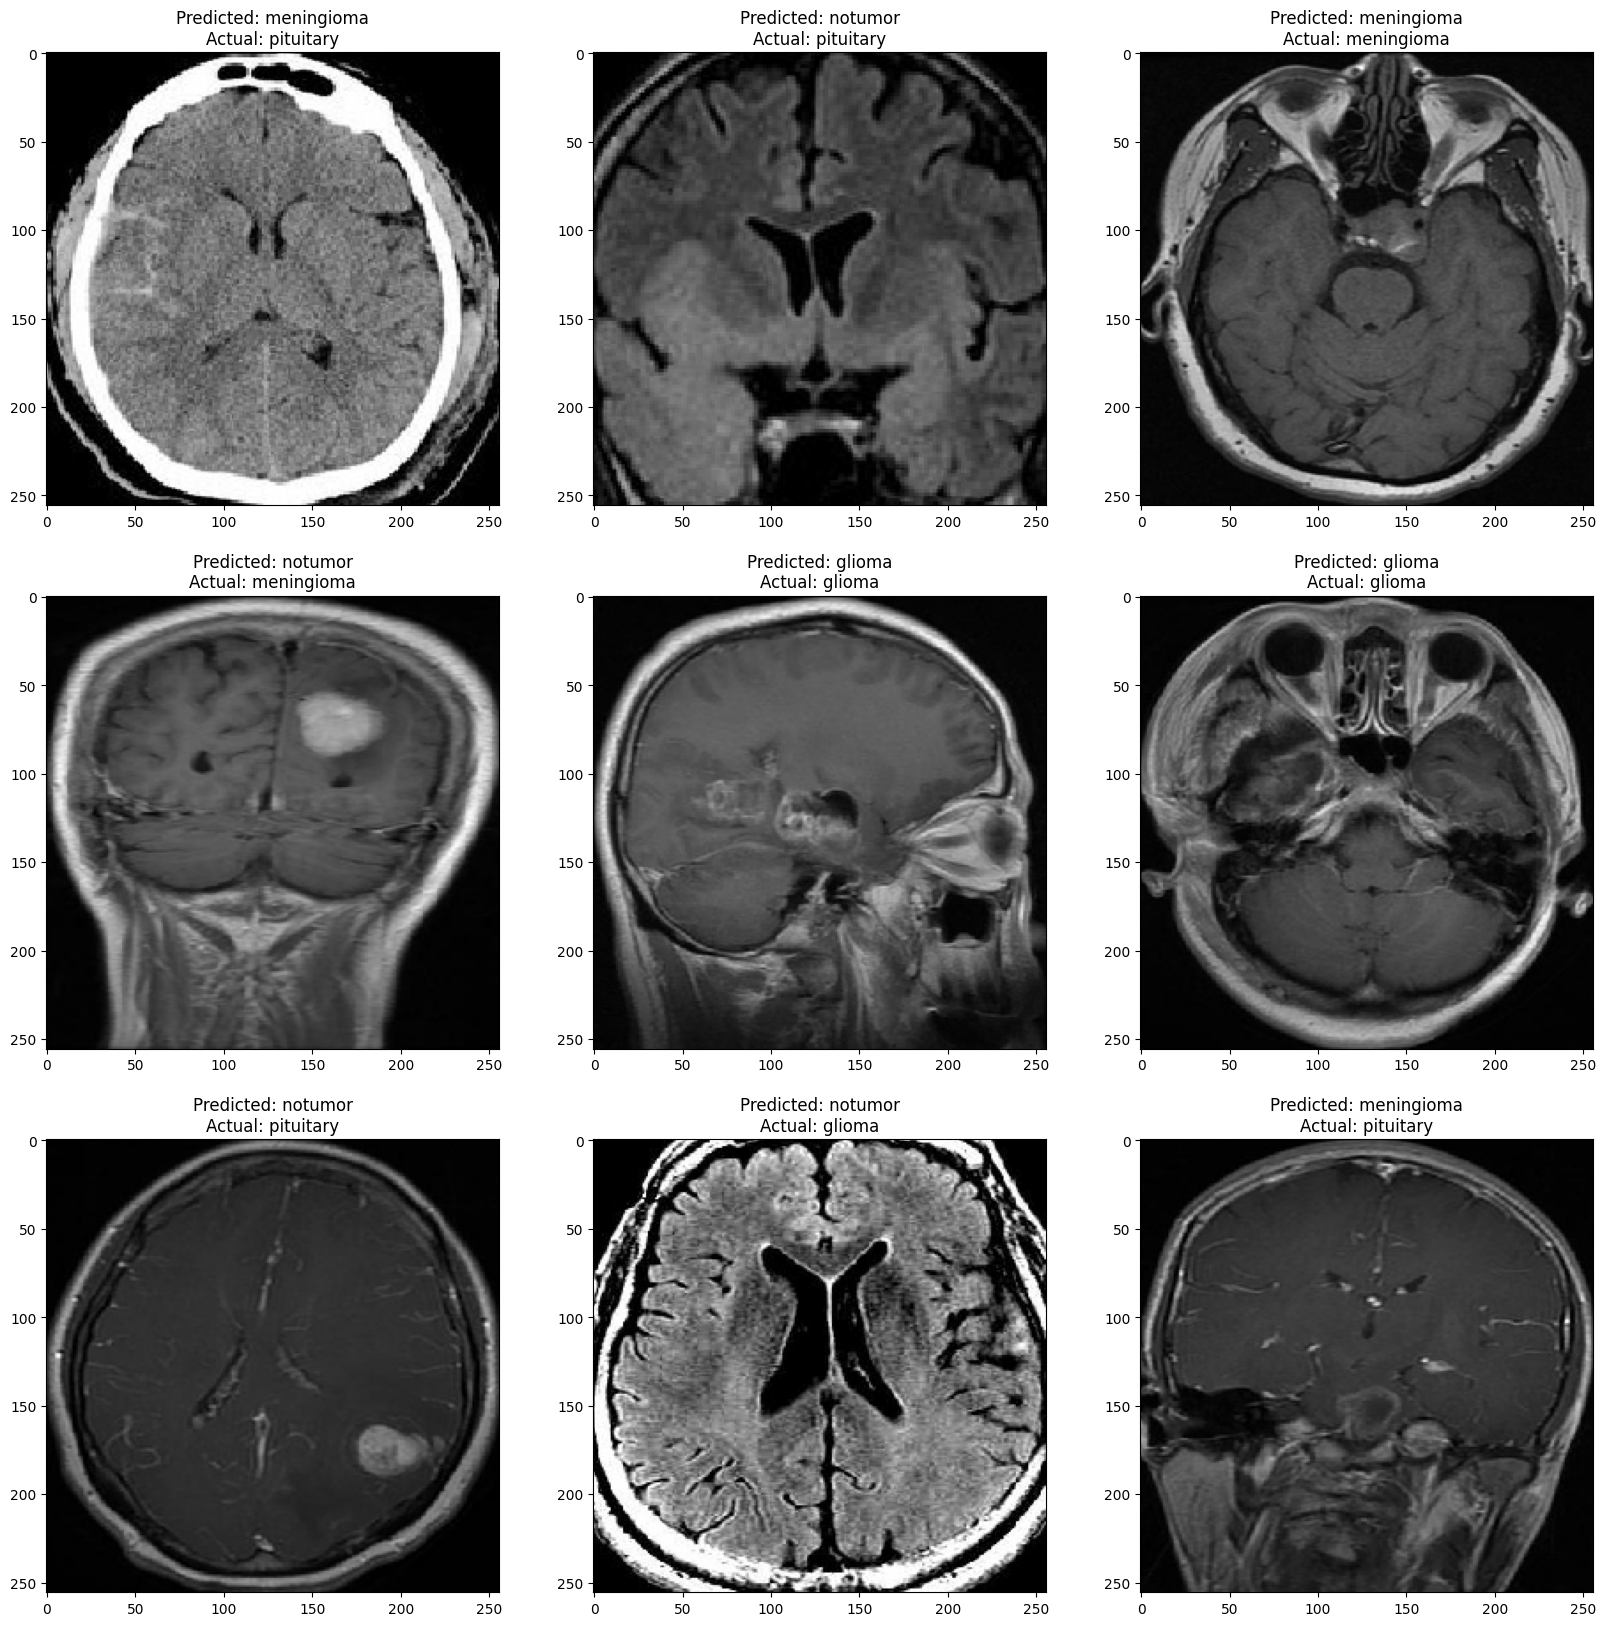

In [13]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(validation_generator)

# Predict the output
predictions = model.predict(validation_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break


# Model Visualisation (Evaluation)

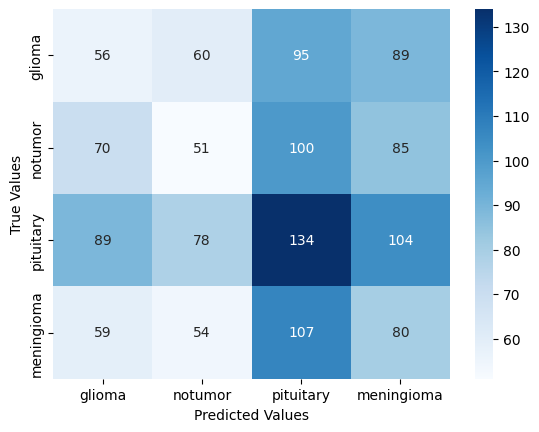

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
